# Shoulder Axis Analysis
## Notes
### LaTeX Rendering
Equations (LaTeX) are not currently supported in mkdocs-jupyter rendering on Safari. Firefox or Chrome is recommended for use to bypass this issue. 

See Github Issue here: https://github.com/danielfrg/mkdocs-jupyter/issues/156. 

## Purpose
This analysis generates the peak torque acting at the shoulder joint of the robot.

This is used to size shoulder motors and calculate motor torques required at each downstream joint.

## FBD
The FBD representing torques acting on the shoulder joint is:

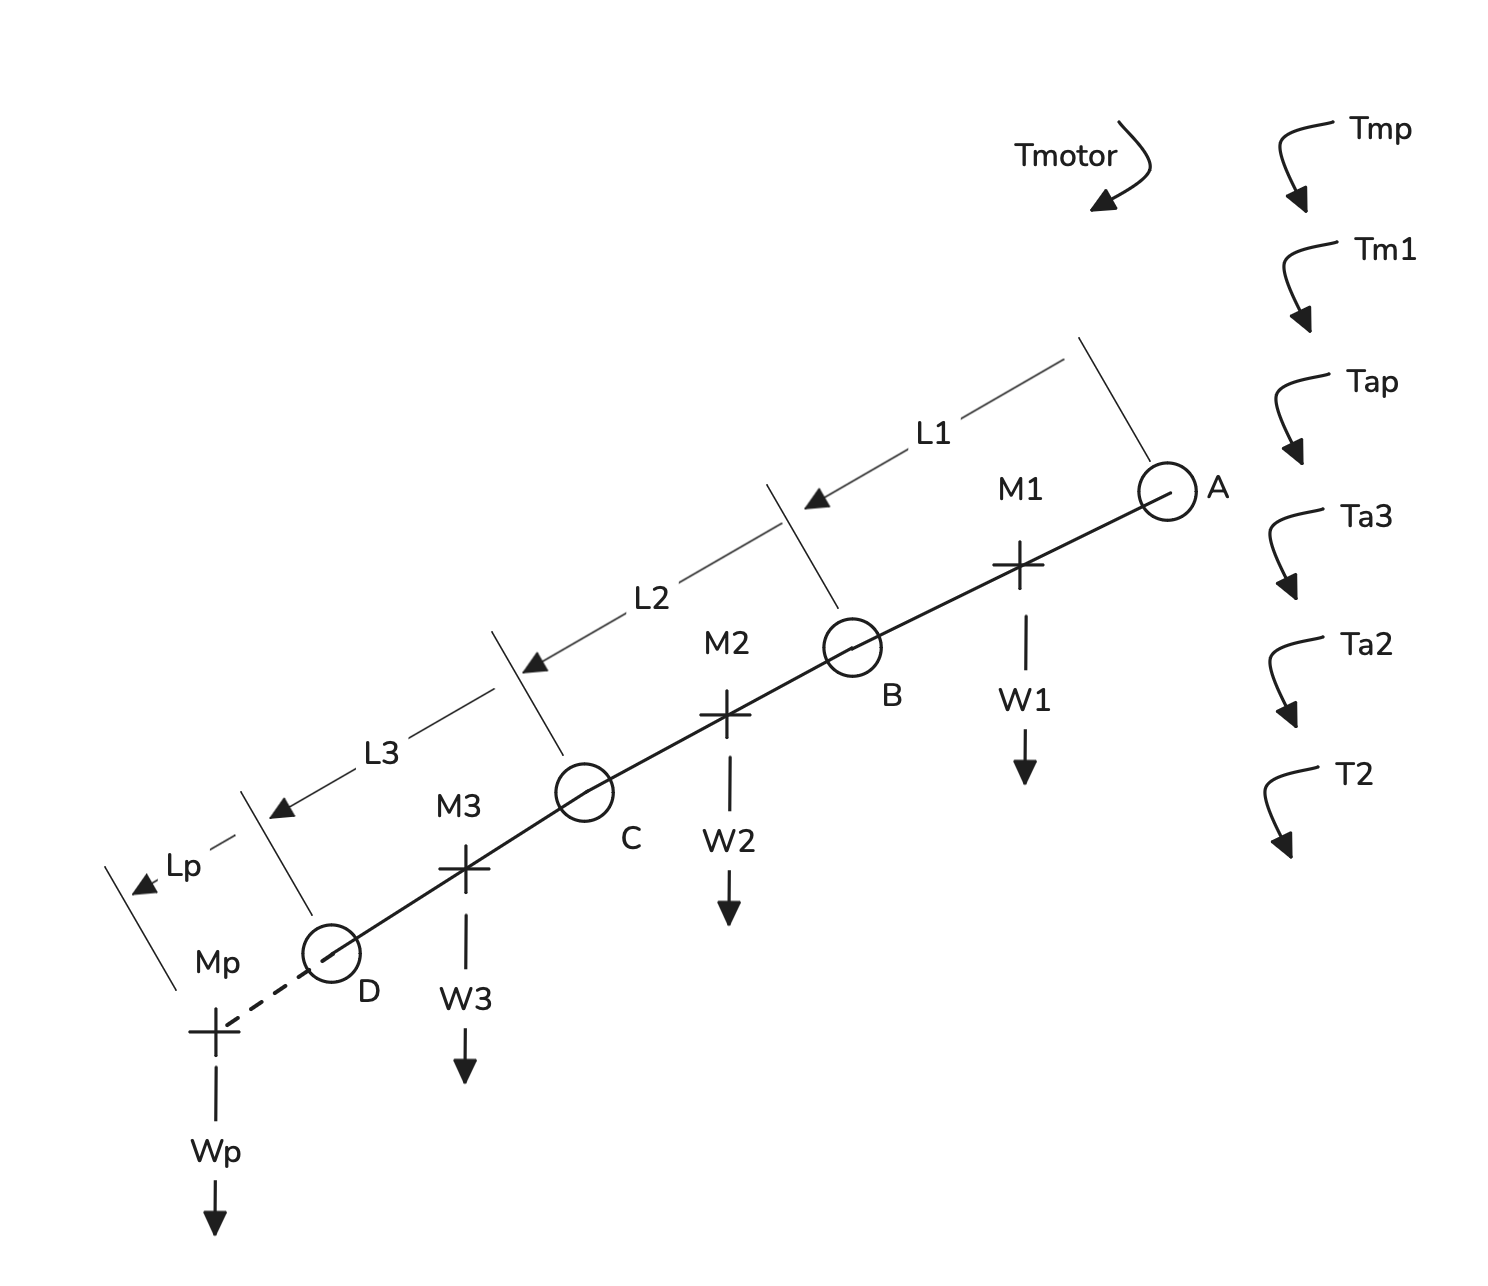

In [1]:
from IPython import display
display.Image('rightArmFBD1.PNG', width=600)

Where:

$T_{mp}$ represents torque of the payload generated about point A.

$T_{m1}$ represents torque of mass 1 (approximation of total) of linkage 1.

# Analysis
2. Sum all torques generated from point masses under gravity in addition to motor torques:

$$
\sum T_A = 0 = T_{motor} -T_{a_{p}} - T_{a_{3}} - T_{a_{2}} - T_{a_{1}} - T_{mp} - T_{m3} - T_{m2} - T_{m1}
$$

*Note that the torques from mass are represented as $T_{a_{i}}$and will be broken into constituent elements (mass times gravity at distance, or weight times distance) later*

3. For preliminary torque calculations and to summarize the torque required at the shoulder motor under worst case load, we can remove the acceleration torques from equation one and consider the system in static loading

$$
\sum T_A = 0 = T_{motor} - T_{mp} - T_{m3} - T_{m2} - T_{m1}
$$


In [2]:
# Base Libraries for all Ondroid projects
import matplotlib, numpy, yaml, pint
import numpy as np

# Boilerplate
## Initialize Pint Registry for Unit Manipulation
## See documentation on Registries and Units in Pint here:
## https://pint.readthedocs.io/en/stable/getting/tutorial.html
from pint import UnitRegistry
ureg = UnitRegistry(auto_reduce_dimensions=True)

In [3]:
preferred_units = [
   ureg.m,  # distance      L
   ureg.kilogram,  # mass          M
   ureg.s,  # duration      T
   ureg.c,  # temperature   Θ
   ureg.newton,  # force         L M T^-2
   ureg.W,  # power         L^2 M T^-3
]

In [4]:
# Dictionary to store the read Pint values
parameters = {}

# Open and read the file
with open('arms.txt', 'r') as file:
    for line in file:
        # Split the line into quantity name and value string
        quantity, value_str = line.strip().split(': ')
        
        # Parse the value string into a Pint quantity
        value = ureg(value_str)
        
        # Store the Pint quantity in the dictionary
        parameters[quantity] = value

In [5]:
# Create parameters
## Arms are defined starting at the shoulder, working down to the hand
parameters['L1'] = 750 * ureg.millimeter
parameters['L2'] = 500 * ureg.millimeter
parameters['L3'] = 150 * ureg.millimeter
parameters['LP'] = 150 * ureg.millimeter

## Masses are defined
## Note: Masses estimated. They need further conceptual design to refine
parameters['m1'] = 2.5 * ureg.kilogram
parameters['m2'] = 2.0 * ureg.kilogram
parameters['m3'] = 0.5 * ureg.kilogram

## A requirement of the project is to be able to lift a gallon of water
parameters['mP'] = 4.0 * ureg.kilogram

In [6]:
# Calculate the weight of each member
w1 = parameters['m1'] * 9.81 * ureg.meter / ureg.second**2
w1 = w1.to(ureg.newton)

w2 = parameters['m2'] * 9.81 * ureg.meter / ureg.second**2
w2 = w2.to(ureg.newton)

w3 = parameters['m3'] * 9.81 * ureg.meter / ureg.second**2
w3 = w3.to(ureg.newton)

wp = parameters['mP'] * 9.81 * ureg.meter / ureg.second**2
wp = wp.to(ureg.newton)

In [14]:
# Calculate the torque acting at the arm as a sum of all torques
# generated about point a.
#
# Note that the lengths are divided by two, as the weight of the member acts 
# at half the length of the member.
#
# The exception to this is the payload, which is measured directly to its center of mass

Tmp = parameters['LP'] * wp
Tm3 = parameters['L3'] * w3
Tm2 = parameters['L2'] * w2
Tm1 = parameters['L1'] * w1

# Finally, the motor torque at the shoulder is:
TMotor = Tmp + Tm3 + Tm2 + Tm1

print(TMotor.to(ureg.m * ureg.N))

34.8255 meter * newton


In [6]:
# Close out file and save manipulated parameters
with open('arms.txt',  'w') as file:
    # Iterate th rough the pint values dictionary
    for quantity, value in parameters.items():
        # Format the value with 6 decimal places
        value_str = f"{quantity}: {value:.6f~P}"
        
        # Write the formatted string to the file, followed by a newline character
        file.write(value_str + '\n')